In [182]:
import numpy as np
from __future__ import print_function
from sklearn import metrics

In [12]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [13]:
labels = ['B-celltypeline',
 'B-cellularcomponent',
 'B-mirna',
 'B-organismsspecies',
 'B-proteingene',
 'B-smallmolecule',
 'B-tissuesorgans',
 'I-celltypeline',
 'I-cellularcomponent',
 'I-organismsspecies',
 'I-proteingene',
 'I-smallmolecule',
 'I-tissuesorgans',
 'O']

In [14]:
def read_file(filename):
    f = open(filename)

    lines = f.readlines()

    sentences = []
    sentence = []
    for l in lines:
        if l == '\n':
            sentences.append(sentence)
            sentence = []
            continue

        sentence.append(l[:-1].split(' '))
        # TODO: utf-8?


    label_stats = {}
    for s in sentences:
        for w in s:
            label = w[1]
            if label not in label_stats:
                label_stats[label] = 0
            label_stats[label] += 1

    X = []
    Y = []
    for s in sentences:
        x = []
        y = []
        for word, label in s:
            x += [ord(w) for w in word]
            y += [labels.index(label) + 1] * len(word)

            x.append(ord(' '))
            y.append(labels.index('O') + 1)

        X.append(x)
        Y.append(y)

    return X,Y,label_stats

In [15]:
trainX, trainY, train_labels = read_file('data_v2/train.iob2')
devX, devY, dev_labels = read_file('data_v2/dev.iob2')
testX, testY, test_labels = read_file('data_v2/test.iob2')

In [16]:
train_labels, dev_labels, test_labels

({'B-celltypeline': 7938,
  'B-cellularcomponent': 5793,
  'B-mirna': 94,
  'B-organismsspecies': 5626,
  'B-proteingene': 33226,
  'B-smallmolecule': 8081,
  'B-tissuesorgans': 4248,
  'I-celltypeline': 1275,
  'I-cellularcomponent': 911,
  'I-organismsspecies': 446,
  'I-proteingene': 812,
  'I-smallmolecule': 583,
  'I-tissuesorgans': 1234,
  'O': 502341},
 {'B-celltypeline': 921,
  'B-cellularcomponent': 522,
  'B-organismsspecies': 838,
  'B-proteingene': 3616,
  'B-smallmolecule': 1250,
  'B-tissuesorgans': 475,
  'I-celltypeline': 130,
  'I-cellularcomponent': 111,
  'I-organismsspecies': 51,
  'I-proteingene': 107,
  'I-smallmolecule': 63,
  'I-tissuesorgans': 132,
  'O': 59002},
 {'B-celltypeline': 911,
  'B-cellularcomponent': 613,
  'B-mirna': 54,
  'B-organismsspecies': 562,
  'B-proteingene': 4165,
  'B-smallmolecule': 803,
  'B-tissuesorgans': 611,
  'I-celltypeline': 144,
  'I-cellularcomponent': 82,
  'I-organismsspecies': 111,
  'I-proteingene': 102,
  'I-smallmolecule

In [150]:
def print_label(l):
    if l == 14:
        print("·", end='')
    else:
        print("%X" % l, end='')
    
def print_seq(x,y,y_true=None,start=0,end=None, line_length=80):
    if end is None:
        end = len(x)
    
    line_count = int(np.ceil(1.0*(end-start)/line_length))
    for line in range(line_count):
        st = start + line * line_length
        en = np.min([end, st + line_length])
        
        if y_true is not None:
            for i in range(st, en):
                print_label(y_true[i])
            print(" ")

        for i in range(st, en):
            print_label(y[i])

        print(" ")
        for i in range(st, en):
            print(chr(x[i]), end='')
        
        print("\n")

In [151]:
print_seq(testX[0], testY[0], None, 0, 100)

····111111·88888·······················555555555································ 
(A) HEK293 cells were transfected with DAPK��CaM or with a control vector (pcDNA

···················· 
3-luciferase, LUC), 



# Neural model

In [19]:
import theano

In [20]:
theano.config.device

'cuda0'

In [21]:
theano.config.optimizer='fast_run'

In [22]:
import keras
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Convolution2D, Embedding, Reshape, BatchNormalization

In [91]:
max_len = 150

In [92]:
def prepare_for_keras(X, Y, max_len):
    X_ = sequence.pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
    
    Y_ = sequence.pad_sequences(Y, maxlen=max_len, padding='post', truncating='post')

    Y_one_hot = np.array([keras.utils.to_categorical(y, num_classes=len(labels) + 1) for y in Y_])
    
    # Convert labels to categorical one-hot encoding
    return X_, Y_one_hot

In [93]:
trainX_, trainY_ = prepare_for_keras(trainX, trainY, max_len)

In [94]:
devX_, devY_ = prepare_for_keras(devX, devY, max_len)

In [95]:
testX_, testY_ = prepare_for_keras(testX, testY, max_len)

In [96]:
train_final_labels = np.argmax(trainY_,-1).reshape(-1)

In [97]:
class_weights = np.zeros(15, dtype=np.float)
for i in range(15):
    class_weights[i] = (train_final_labels==i).sum()

In [99]:
class_weights = class_weights.sum() / class_weights
class_weights[0] = 0

In [163]:
from keras.losses import categorical_crossentropy
def categorical_crossentropy_flatten(y_true, y_pred):
    tmp = categorical_crossentropy(y_true, y_pred)
    y_true_argmax = y_true.argmax(axis=-1)
    weights = K.constant(
        # class_weights
        np.log(class_weights+1)
#         np.sqrt(class_weights)
    )[y_true_argmax]
    
    return tmp * weights

In [153]:

model = Sequential()
model.add(Embedding(256, 16, mask_zero=False, input_length=max_len))
print(model.layers[-1].output_shape)

model.add(Reshape(target_shape=(-1,16,1)))
print(model.layers[-1].output_shape)

model.add(Convolution2D(16, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
print(model.layers[-1].output_shape)

for i in range(4):
    model.add(Convolution2D(16, 5, strides=(1,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    print(model.layers[-1].output_shape)
    
    model.add(Convolution2D(16, 5, strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    print(model.layers[-1].output_shape)

model.add(Convolution2D(len(labels) + 1, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
print(model.layers[-1].output_shape)

model.add(Reshape((-1, len(labels) + 1)))
print(model.layers[-1].output_shape)

model.add(Activation('softmax', name='last_softmax'))
print(model.layers[-1].output_shape)

#model.add(FlattenFirst())
#print(model.layers[-1].output_shape)

model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss=categorical_crossentropy_flatten,
              metrics=['accuracy'])

(None, 150, 16)
(None, 150, 16, 1)
(None, 150, 16, 16)
(None, 150, 8, 16)
(None, 150, 8, 16)
(None, 150, 4, 16)
(None, 150, 4, 16)
(None, 150, 2, 16)
(None, 150, 2, 16)
(None, 150, 1, 16)
(None, 150, 1, 16)
(None, 150, 1, 15)
(None, 150, 15)
(None, 150, 15)


In [ ]:
history = model.fit(
    trainX_, 
    trainY_, 
    epochs=30, batch_size=64, validation_data=(devX_, devY_),
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            'logarithm.weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
            monitor='val_loss', verbose=1, 
            save_best_only=True, save_weights_only=False, mode='auto', period=1)
    ]
)

Train on 34307 samples, validate on 4037 samples
Epoch 1/30
34307/34307 [==============================] - 415s - loss: 1.0126 - acc: 0.5529 - val_loss: 0.8956 - val_acc: 0.5406
Epoch 2/30
34307/34307 [==============================] - 413s - loss: 0.5926 - acc: 0.5808 - val_loss: 0.7682 - val_acc: 0.5363
Epoch 3/30
34307/34307 [==============================] - 415s - loss: 0.4926 - acc: 0.5873 - val_loss: 0.6723 - val_acc: 0.5519
Epoch 4/30
34307/34307 [==============================] - 418s - loss: 0.4308 - acc: 0.5911 - val_loss: 0.6464 - val_acc: 0.5420
Epoch 5/30
34307/34307 [==============================] - 412s - loss: 0.2288 - acc: 0.6048 - val_loss: 0.9471 - val_acc: 0.4326
Epoch 16/30
34307/34307 [==============================] - 413s - loss: 0.2503 - acc: 0.6023 - val_loss: 0.5243 - val_acc: 0.5676
Epoch 17/30
34307/34307 [==============================] - 411s - loss: 0.2151 - acc: 0.6060 - val_loss: 0.5409 - val_acc: 0.5732
Epoch 18/30
34307/34307 [=====================

KeyboardInterrupt: 

In [181]:
history = _

In [121]:
history.history

{'acc': [0.56307847817720313, 0.58468087056149665, 0.58907647564892973],
 'loss': [0.92062546304686688, 0.56125873207201593, 0.42611502585091876],
 'val_acc': [0.55477664918482583, 0.56585748271833469, 0.56539509634600138],
 'val_loss': [0.91104308270141277, 0.6382049679615901, 0.60334992368703499]}

In [73]:
history.history

{'acc': [0.56684369528728307, 0.58285753117552253],
 'loss': [0.83355488851251647, 0.49912513541983139],
 'val_acc': [0.55187515402847154, 0.56986540996676949],
 'val_loss': [0.66475501503903356, 0.5986078367179829]}

In [161]:
from keras.models import load_model

In [173]:
loadedmodel = load_model('logarithm.weights.15-0.52.hdf5', custom_objects=locals())

In [74]:
train_pred = model.predict_classes(trainX_, batch_size=64)

train_truth = np.argmax(trainY_, -1)
nonzero = train_truth != 0
t = (train_pred[nonzero] == train_truth[nonzero]).sum()
t1 = nonzero.sum()
print("char level accuracy:", 1.0*t/t1)

cm = metrics.confusion_matrix(train_truth.flatten(), train_pred.flatten())

34304/34307 [============================>.] - ETA: 0s

In [174]:
dev_pred = loadedmodel.predict_classes(devX_, batch_size=64)

dev_truth = np.argmax(devY_, -1)
nonzero = dev_truth != 0
t = (dev_pred[nonzero] == dev_truth[nonzero]).sum()
t1 = nonzero.sum() # dev_pred.shape[0]*dev_pred.shape[1]
print("char level accuracy:", 1.0*t/t1)

cm = metrics.confusion_matrix(dev_truth.flatten(), dev_pred.flatten())

4032/4037 [============================>.] - ETA: 0schar level accuracy: 0.913606366099


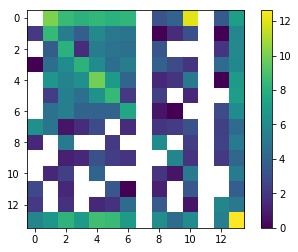

In [180]:
plt.imshow(np.log(cm))
plt.colorbar()

In [181]:
for i in range(100):
    print_seq(devX_[i], devY_[i].argmax(axis=-1), dev_pred[i], end=150)
    print("\n")

······················777777777·······················55555555555·44444········· 
······················7777777777·DDDDDD···············55555555555·44444········· 
(A) Sections from the cerebellar vermis of a 70-d-old npc1���/��� mouse were sta

··········55555555555555······················111······666············ 
··········55555555555555······················111····················2 
ined with anti-Calbindin (green) to visualize PCs and 7AAD (red) for n



···················1·····111·················2·2·········111···················· 
·························111··············777777·DDD·····111····777777·D········ 
Although there are scant PCs remaining in lobule II, the PCs in lobule X have no

·············71111111111BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB47256 
·············000000000000000000000000000000000000000000000000000000000 
t decreased.                                                          



···································7777777····666666564·44········711111

                                                                      



·········444444································································· 
·········444444································································· 
For each mouse, the actual density observed (the average of the mean densities c

································································44···· 
································································11···· 
ounted in each lobule) is compared to the number expected if no PC los



···································································444444·441111 
···································································444444·000000 
Five sections separated by at least 100 ��m were analyzed for each mouse.       

111BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB47256 
0000000000000000000000000000000000000000000000000000000000000000000000 
                                                                      



0000000000000000000000000000000000000000000000000000000000000000000000 
                                                                      



·················77·····D······6····················55555555555·5555555555555··1 
·················11·································55555555555················1 
A stretch of the PC layer in C4.8 is shown where no npc1���/��� (GFP-positive) P

11···································································· 
11···································································· 
Cs remain despite the presence of numerous wild-type (GFP-negative) gl



····································111································555555555 
····································111································555555555 
The space occupied by two wild-type PCs is indicated (arrows) with two npc1���/�

55·55555555555555·1111·······················7711111111BBBBBBBBBB47256 
55··········································00000000000000000000000000 


····························································22222222222222·····2 
···············································································2 
(B) Magnification of the red box in (A) showing accumulated multivesicular and m

222222222222·22222299222·22122111111BBBBBBBBBBBBBBBBBBBBBBBBBBBBB47256 
222222222222·99999999999·000000000000000000000000000000000000000000000 
ultilamellar organelles.                                              



·························································22····················· 
·························································22····················· 
(C) Magnification of the blue box in (A) showing a large AV (arrowheads) contain

····222222222·····2222222222·222221111BBBBBBBBBBBBBBBBBBBBBBBBBBB47256 
····222222222·····2222222222·00000000000000000000000000000000000000000 
ing ribosomes and membranes.                                          



············22··················22·999·999··············777777·777711111

(C) Cells were grown in control or in starvation medium and visualized by light 

·············2111111111BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB47256 
············0000000000000000000000000000000000000000000000000000000000 
microscopy.                                                           



····················22222222222222222222·999999999·2222························· 
····················22222222222222222222·999999999·999999······················· 
Arrows point to the pre���autophagosomal structure (PAS), and arrowheads point t

·················222222222·2·22221111BBBBBBBBBBBBBBBBBBBBBBBBBBBB47256 
·················222222222·0000000000000000000000000000000000000000000 
o GFP within the vacuoles.                                            





In [190]:
def print_word(word, label_votes, f):
    label = labels[label_votes.argmax()]
    f.write("{} {}\n".format(''.join(word), label))

def print_iob2(X, Y, f):
    for xsentence, ysentence in zip(X,Y):
        word = []
        votes = np.zeros(len(labels))
        for x,y in zip(xsentence, ysentence):
            if chr(x)==' ':
                print_word(word, votes, f)
                word = []
                votes = np.zeros(len(labels))
                continue
            word.append(chr(x))
            votes[y-1] += 1
        f.write("\n")

# Save to file

In [204]:
coef = 4
devX_full, devY_full = prepare_for_keras(testX, testY, max_len * coef)

In [205]:
dev_pred_full = None
for i in range(coef):
    t = loadedmodel.predict_classes(
        devX_full[:,i*max_len:(i+1)*max_len], batch_size=64)
    if dev_pred_full is None:
        dev_pred_full = t
    else:
        dev_pred_full = np.concatenate([dev_pred_full, t], axis=1)

print(dev_pred_full.shape)

dev_truth_full = np.argmax(devY_full, -1)
nonzero = dev_truth_full != 0
t = (dev_pred_full[nonzero] == dev_truth_full[nonzero]).sum()
t1 = nonzero.sum() # dev_pred.shape[0]*dev_pred.shape[1]
print("char level accuracy:", 1.0*t/t1)

cm = metrics.confusion_matrix(dev_truth_full.flatten(), dev_pred_full.flatten())

4243/4243 [==============================] - 16s    
(4243, 600)
char level accuracy: 0.922324055216


In [208]:
for i in range(10):
    print_seq(devX_full[i], devY_full[i].argmax(axis=-1), dev_pred_full[i])
    print("\n")

····111111·····························555555555··························555555 
····111111·88888·······················555555555································ 
(A) HEK293 cells were transfected with DAPK��CaM or with a control vector (pcDNA

5555555522222·22222································555555·B····555·············5 
···················································555555·B····················5 
3-luciferase, LUC), together with shRNAs targeting beclin 1 or HcRed, and with G

555555··········11111111111BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB 
555555··········0000000000000000000000000000000000000000000000000000000000000000 
FP-LC3 plasmid.                                                                 

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB472561111111BBBBBBBBBBBBB 
00000000000000000000000000000000000000000000000000000000000000000000000000000000 
                                                                                

BBBBBBBBBBBBBBBB

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB 
00000000000000000000000000000000000000000000000000000000000000000000000000000000 
                                                                                

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB472561111111BBBBBBBBBBBBBBBBBBBBBBB 
00000000000000000000000000000000000000000000000000000000000000000000000000000000 
                                                                                

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB 
00000000000000000000000000000000000000000000000000000000000000000000000000000000 
                                                                                

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB47256 
0000000000000000000000000000000000000000 
                                        



········································································22111111 
····················································

In [207]:
print_iob2(devX_full, dev_pred_full, open('test_pred.iob2', 'w'))